In [5]:
import pandas as pd
import numpy as np
import csv
import os 
import xml.etree.ElementTree as ET
import xml.dom.minidom
import zipfile
import glob
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.colors as mcolors


In [6]:
os.chdir("C:\\Users\\Veli\\Downloads\\Code\\data")

In [7]:
tree = ET.parse("ADDERALL_prod_no_1.xml")
root = tree.getroot()

In [8]:
text_data = []
for element in root.iter():
    text = element.text
    if text is not None:
        text_data.append(text.strip())

Here I am printing the raw text removing the xml formatting to see what is contained within the drug label information files. As you can see there are a lot of useless text information that will be uninformative when applying text analysis. I will have to parse through the xml attributes to get the elements of interest.

In [9]:
for text in text_data:
    print(text)



Adderall
®
Rx only



Teva Pharmaceuticals USA, Inc.








Adderall


Dextroamphetamine Saccharate, Amphetamine Aspartate, Dextroamphetamine Sulfate, and Amphetamine Sulfate



DEXTROAMPHETAMINE SACCHARATE


DEXTROAMPHETAMINE



AMPHETAMINE ASPARTATE MONOHYDRATE


AMPHETAMINE



DEXTROAMPHETAMINE SULFATE


DEXTROAMPHETAMINE



AMPHETAMINE SULFATE


AMPHETAMINE


SILICON DIOXIDE


SUCROSE


MALTODEXTRIN


STARCH, CORN


MAGNESIUM STEARATE


CELLULOSE, MICROCRYSTALLINE


SACCHARIN SODIUM





















white to off-white


5;dp











Adderall


Dextroamphetamine Saccharate, Amphetamine Aspartate, Dextroamphetamine Sulfate, and Amphetamine Sulfate



DEXTROAMPHETAMINE SACCHARATE


DEXTROAMPHETAMINE



AMPHETAMINE ASPARTATE MONOHYDRATE


AMPHETAMINE



DEXTROAMPHETAMINE SULFATE


DEXTROAMPHETAMINE



AMPHETAMINE SULFATE


AMPHETAMINE


SILICON DIOXIDE


SUCROSE


MALTODEXTRIN


STARCH, CORN


MAGNESIUM STEARATE


CELLULOSE, MICROCRYSTALLINE


SACCHARIN SODIUM


FD&C BLUE NO.

Here I am setting up the parsing object for the xml files.

In [12]:
domtree = xml.dom.minidom.parse("ADDERALL_prod_no_1.xml")
group = domtree.documentElement

Here is a function that extracts all the text from the paragraph tags in the xml file format.

In [11]:
def xml_to_str(filename):
    
    domtree = xml.dom.minidom.parse(filename)
    group = domtree.documentElement
    paragraph_elements = group.getElementsByTagName("paragraph")
    
    text_data = []
    
    for i in range(len(paragraph_elements)):
        #if paragraph_elements[i].firstChild is None:
        #    continue
        #print(paragraph_elements[i].firstChild.nodeValue)
        if paragraph_elements[i].firstChild is not None:
            text_data.append(paragraph_elements[i].firstChild.nodeValue)
    
    #Dropping Elements of text_data that only contain empty spaces and \n
    text_filtered = [i for i in text_data if not all(j in ["\n", " "] for j in i)]
    #Dropping empty space and \n within each element of text_data
    text_within = [i.replace("\n", "").replace("  ", " ").strip() for i in text_filtered if not (i.replace("\n", "").replace("  ", " ").strip() == "")]
    
    text_str = ''.join(text_within)
    
    return text_str


In [14]:
text_data = xml_to_str("ADDERALL_prod_no_1.xml")

In [15]:
text_data

'A single-entity amphetamine product combining the neutral sulfate salts of dextroamphetamine and amphetamine, with the dextro isomer of amphetamine saccharate and d, l-amphetamine aspartate.DextroamphetamineSaccharate1.25 mg1.875 mg2.5 mg3.125 mg3.75 mg5 mg7.5 mgAmphetamine Aspartate Monohydrate Equivalent1.25 mg1.875 mg2.5 mg3.125 mg3.75 mg5 mg7.5 mgDextroamphetamineSulfate, USP1.25 mg1.875 mg2.5 mg3.125 mg3.75 mg5 mg7.5 mgAmphetamineSulfate, USP1.25 mg1.875 mg2.5 mg3.125 mg3.75 mg5 mg7.5 mgTotal Amphetamine Base Equivalence3.13 mg4.7 mg6.3 mg7.8 mg9.4 mg12.6 mg18.8 mgAdderallAdderallAmphetamines are non-catecholamine sympathomimetic amines with CNS stimulant activity. The mode of therapeutic action in Attention Deficit Hyperactivity Disorder (ADHD) is not known. Amphetamines are thought to block the reuptake of norepinephrine and dopamine into the presynaptic neuron and increase the release of these monoamines into the extraneuronal space.AdderallThe effect of food on the bioavailab

Now that we are able to extract the necessary information from each drug label file, we can move on to the next step. First, there is some pre-processing we have to do. The files that were scraped from DailyMed still need to renamed so that we know what drug each file is associated with. From the scraping script I also generated a dictionary file to match NDC codes with drug label files. I will use this dictionary key to rename the zip files. 

In [16]:
column_types = {
    'NDC': str,
    'filename': str,

}

# Read the CSV file and specify the column types
ref_file = pd.read_csv("ref.csv", dtype=column_types)

# Perform operations on the DataFrame
# ...


In [17]:
ref_file

,NDC,filename
0,00228202950,a23063c0-099a-4256-b95f-3a857bbf704b
1,00228305911,c5c2d060-452c-4f76-ad93-2e41fd8f06c2
2,10702010101,1bf37f9f-29cf-4b09-9c81-eb369e35a042
3,13107008305,5b851f67-309d-4ef3-8b4b-ade8908256ea
4,13811070910,c45dc1de-adfa-4b3c-a7dc-cffbc8eac74f
...,...,...
1218,24338003501,1e25f905-6c0b-4b19-a3b6-b2a386afa1c3
1219,65162023509,34de1806-d921-4d2f-8c7f-03625b717a70
1220,53746011005,e0cefc7b-e81c-4e15-89a0-fe71dc94338b
1221,70165010030,33f70f58-c871-42c8-8adb-345caeafefcd


As we can see there are multiple NDC codes related to the some package label. This is because 11-digit NDC codes are associated with a particular package size which is not informative for our purposes. Therefore we can drop some NDC codes from the table. 

In [8]:
print(f"There are {len(ref_file['NDC'].unique())} unique NDC codes")
print(f"There are {len(ref_file['filename'].unique())} drug label files")

There are 1223 unique NDC codes
There are 481 drug label files


In [18]:
grouped_df = ref_file.groupby("filename").agg({'NDC': list})
grouped_df

,NDC
filename,
007bf37f-0e46-426a-ac8c-be63d4b7414c,"[29300035505, 29300035501]"
010905f9-3bcb-4b50-9fe8-a3ad0010f14c,[00054024425]
01db4606-d49c-4b10-a78a-1cf41880a9fb,[31722091701]
01f6690c-1410-42ad-8eb3-e7df32eab3ba,"[42043016103, 42043016003]"
021153ce-fe27-4ed1-8d88-b4157b0ed734,"[71093015504, 71093015604, 71093015606]"
...,...
fcd2b59e-8087-475e-9e6b-911bd846ea96,"[71930002012, 71930001912, 71930001952, 719300..."
fe126254-6ee6-48c3-965c-96e4276a5314,"[58657050016, 58657050004]"
fe874f8a-4b56-4d2b-abf5-8742e2633a3b,[16571067516]


Here I will be using only the first NDC code from every list of NDC codes associated with a specific drug label file.

In [19]:
for i in range(len(grouped_df)):
    grouped_df['NDC'][i] = list(grouped_df.iloc[i])[0][0]

In [20]:
grouped_df = grouped_df.reset_index()
grouped_df

,filename,NDC
0,007bf37f-0e46-426a-ac8c-be63d4b7414c,29300035505
1,010905f9-3bcb-4b50-9fe8-a3ad0010f14c,00054024425
2,01db4606-d49c-4b10-a78a-1cf41880a9fb,31722091701
3,01f6690c-1410-42ad-8eb3-e7df32eab3ba,42043016103
4,021153ce-fe27-4ed1-8d88-b4157b0ed734,71093015504
...,...,...
476,fcd2b59e-8087-475e-9e6b-911bd846ea96,71930002012
477,fe126254-6ee6-48c3-965c-96e4276a5314,58657050016
478,fe874f8a-4b56-4d2b-abf5-8742e2633a3b,16571067516
479,ff1630b4-2044-433c-96bc-0bb4ae8d42a0,49884011174


In [21]:
claims_2021 = pd.read_csv('NH_MA_data_2021.csv', 
                          dtype={"NDC":str})

In [22]:
claims_2021

,PROV_KEY,PROV_CW_KEY,FACILITY_NAME,PROV_TYPE,PROV_TYPE_ORIG,PROV_CLINIC_STATE,NH_COUNTY_CODE,NDC,COVERAGE_CLASS,FROM_YEAR,...,NONPROPRIETARYNAME,DOSAGEFORMNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,DEASCHEDULE,NDCPACKAGECODE,PACKAGEDESCRIPTION,STARTMARKETINGDATE,ENDMARKETINGDATE
0,21207,2853,PROVIDER NAME RESTRICTED,PERSON,1,MA,999,00228202950,PHM,2021,...,Alprazolam,TABLET,ALPRAZOLAM,.5,mg/1,CIV,0228-2029-50,500 TABLET in 1 BOTTLE (0228-2029-50),19931001,NaN
1,21207,2853,PROVIDER NAME RESTRICTED,PERSON,1,MA,999,00228202950,PHM,2021,...,Alprazolam,TABLET,ALPRAZOLAM,.5,mg/1,CIV,0228-2029-50,500 TABLET in 1 BOTTLE (0228-2029-50),19931001,NaN
2,21207,2853,PROVIDER NAME RESTRICTED,PERSON,1,MA,999,00228305911,PHM,2021,...,"Dextroamphetamine saccharate, amphetamine aspa...","CAPSULE, EXTENDED RELEASE",AMPHETAMINE ASPARTATE MONOHYDRATE; AMPHETAMINE...,2.5; 2.5; 2.5; 2.5,mg/1; mg/1; mg/1; mg/1,CII,0228-3059-11,"100 CAPSULE, EXTENDED RELEASE in 1 BOTTLE (022...",20120622,NaN
3,21207,2853,PROVIDER NAME RESTRICTED,PERSON,1,MA,999,10702010101,PHM,2021,...,Methylphenidate Hydrochloride,TABLET,METHYLPHENIDATE HYDROCHLORIDE,10,mg/1,CII,10702-101-01,100 TABLET in 1 BOTTLE (10702-101-01),20170511,NaN
4,21207,2853,PROVIDER NAME RESTRICTED,PERSON,1,MA,999,13107008305,PHM,2021,...,Lorazepam,TABLET,LORAZEPAM,.5,mg/1,CIV,13107-083-05,500 TABLET in 1 BOTTLE (13107-083-05),20170324,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80206,1319780,585179,KERRY WU DENTAL OFFICE PC,PROF GRP,2,NH,11,69315090601,PHM,2021,...,Lorazepam,TABLET,LORAZEPAM,2,mg/1,CIV,69315-906-01,100 TABLET in 1 BOTTLE (69315-906-01),20230516,NaN
80207,1319780,585179,KERRY WU DENTAL OFFICE PC,PROF GRP,2,NH,11,69315090601,PHM,2021,...,Lorazepam,TABLET,LORAZEPAM,2,mg/1,CIV,69315-906-01,100 TABLET in 1 BOTTLE (69315-906-01),20230516,NaN
80208,1319780,585179,KERRY WU DENTAL OFFICE PC,PROF GRP,2,NH,11,69315090601,PHM,2021,...,Lorazepam,TABLET,LORAZEPAM,2,mg/1,CIV,69315-906-01,100 TABLET in 1 BOTTLE (69315-906-01),20230516,NaN
80209,1245747,51272,PROVIDER NAME RESTRICTED,PERSON,1,NH,1,43547040610,PHM,2021,...,clonazepam,TABLET,CLONAZEPAM,.5,mg/1,CIV,43547-406-10,"100 TABLET in 1 BOTTLE, PLASTIC (43547-406-10)",20180215,NaN


In [23]:
merged_df = pd.merge(grouped_df, claims_2021, on='NDC', how = 'left').drop_duplicates()
merged_df

,filename,NDC,PROV_KEY,PROV_CW_KEY,FACILITY_NAME,PROV_TYPE,PROV_TYPE_ORIG,PROV_CLINIC_STATE,NH_COUNTY_CODE,COVERAGE_CLASS,...,NONPROPRIETARYNAME,DOSAGEFORMNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,DEASCHEDULE,NDCPACKAGECODE,PACKAGEDESCRIPTION,STARTMARKETINGDATE,ENDMARKETINGDATE
0,007bf37f-0e46-426a-ac8c-be63d4b7414c,29300035505,335662,43839,PROVIDER NAME RESTRICTED,RETAIL,-1,NH,11,PHM,...,Tramadol Hydrochloride,"TABLET, FILM COATED",TRAMADOL HYDROCHLORIDE,50,mg/1,CIV,29300-355-05,"500 TABLET, FILM COATED in 1 BOTTLE, PLASTIC (...",20191104,NaN
1,007bf37f-0e46-426a-ac8c-be63d4b7414c,29300035505,335662,43839,PROVIDER NAME RESTRICTED,RETAIL,-1,NH,11,PHM,...,Tramadol Hydrochloride,"TABLET, FILM COATED",TRAMADOL HYDROCHLORIDE,50,mg/1,CIV,29300-355-05,"500 TABLET, FILM COATED in 1 BOTTLE, PLASTIC (...",20191104,NaN
2,007bf37f-0e46-426a-ac8c-be63d4b7414c,29300035505,335662,43839,PROVIDER NAME RESTRICTED,RETAIL,-1,NH,11,PHM,...,Tramadol Hydrochloride,"TABLET, FILM COATED",TRAMADOL HYDROCHLORIDE,50,mg/1,CIV,29300-355-05,"500 TABLET, FILM COATED in 1 BOTTLE, PLASTIC (...",20191104,NaN
3,007bf37f-0e46-426a-ac8c-be63d4b7414c,29300035505,616707,30584,WALGREEN CO.,RETAIL,2,MA,999,PHM,...,Tramadol Hydrochloride,"TABLET, FILM COATED",TRAMADOL HYDROCHLORIDE,50,mg/1,CIV,29300-355-05,"500 TABLET, FILM COATED in 1 BOTTLE, PLASTIC (...",20191104,NaN
4,007bf37f-0e46-426a-ac8c-be63d4b7414c,29300035505,711202,11179,PROVIDER NAME RESTRICTED,PERSON,1,NH,17,PHM,...,Tramadol Hydrochloride,"TABLET, FILM COATED",TRAMADOL HYDROCHLORIDE,50,mg/1,CIV,29300-355-05,"500 TABLET, FILM COATED in 1 BOTTLE, PLASTIC (...",20191104,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29593,fe874f8a-4b56-4d2b-abf5-8742e2633a3b,16571067516,46603,47844,PROVIDER NAME RESTRICTED,PERSON,1,NH,9,PHM,...,Phenobarbital,LIQUID,PHENOBARBITAL,20,mg/5mL,CIV,16571-675-16,473 mL in 1 BOTTLE (16571-675-16),20200901,NaN
29594,fe874f8a-4b56-4d2b-abf5-8742e2633a3b,16571067516,46603,47844,PROVIDER NAME RESTRICTED,PERSON,1,NH,9,PHM,...,Phenobarbital,LIQUID,PHENOBARBITAL,20,mg/5mL,CIV,16571-675-16,473 mL in 1 BOTTLE (16571-675-16),20200901,NaN
29595,ff1630b4-2044-433c-96bc-0bb4ae8d42a0,49884011174,18532,7814,PROVIDER NAME RESTRICTED,PERSON,1,NH,9,PHM,...,alprazolam,"TABLET, ORALLY DISINTEGRATING",ALPRAZOLAM,.5,mg/1,CIV,49884-111-74,10 BLISTER PACK in 1 CARTON (49884-111-74) / ...,20090109,NaN
29596,ff1630b4-2044-433c-96bc-0bb4ae8d42a0,49884011174,33721,45264,PROVIDER NAME RESTRICTED,PERSON,1,NH,11,PHM,...,alprazolam,"TABLET, ORALLY DISINTEGRATING",ALPRAZOLAM,.5,mg/1,CIV,49884-111-74,10 BLISTER PACK in 1 CARTON (49884-111-74) / ...,20090109,NaN


In [41]:
len(merged_df['NDC_PROD_NAME'].unique())

164

In [24]:
grouped_by_prod_name = merged_df.groupby('NDC_PROD_NAME')['filename'].unique().reset_index()

In [25]:
grouped_by_prod_name

,NDC_PROD_NAME,filename
0,ACETAMINOPHEN/CODEINE,"[02386806-02d4-47e3-9c8b-7810146ee795, 83a536d..."
1,ACETAMINOPHEN/CODEINE PHO,"[79377617-686b-4640-b2b8-e1358cf82358, 8bc4108..."
2,ADDERALL,[f22635fe-821d-4cde-aa12-419f8b53db81]
3,ADDERALL XR,[aff45863-ffe1-4d4f-8acf-c7081512a6c0]
4,ADHANSIA XR,[80e15bd0-4d56-75f0-ab5a-885879fc56e9]
...,...,...
159,XYOSTED,[8a3d204c-be26-49e0-8599-0ac12a272e81]
160,ZALEPLON,"[47303145-6788-46bd-b9cc-37b59b145cea, 57a1a11..."
161,ZOLPIDEM TARTRATE,"[021153ce-fe27-4ed1-8d88-b4157b0ed734, 0553e26..."
162,ZOLPIDEM TARTRATE ER,"[0c64bc71-2e7f-4b15-a8e1-acb8de04395f, 1a32885..."


From the output below we can see that for some drugs there are multiple products offered. These products tend to be very similar from one another but may differ in their rate of absorption and metabolism, method of ingestion, and other characteristics. 

In [30]:
for i in range(len(grouped_by_prod_name)):
    if len(grouped_by_prod_name.iloc[i][1]) > 1:
        print(f"{grouped_by_prod_name.iloc[i][0]} has {len(grouped_by_prod_name.iloc[i][1])} different products")

ACETAMINOPHEN/CODEINE has 3 different products
ACETAMINOPHEN/CODEINE PHO has 2 different products
ALPRAZOLAM has 5 different products
ALPRAZOLAM ER has 2 different products
ALPRAZOLAM ODT has 2 different products
AMPHETAMINE SULFATE has 2 different products
AMPHETAMINE/DEXTROAMPHETA has 22 different products
ARMODAFINIL has 4 different products
BUPRENORPHINE has 3 different products
BUPRENORPHINE HCL has 5 different products
BUPRENORPHINE HCL/NALOXON has 4 different products
BUPRENORPHINE HYDROCHLORI has 5 different products
BUTALBITAL/ACETAMINOPHEN/ has 10 different products
BUTALBITAL/ASPIRIN/CAFFEI has 3 different products
BUTORPHANOL TARTRATE has 2 different products
CARISOPRODOL has 8 different products
CHLORDIAZEPOXIDE HCL has 2 different products
CLOBAZAM has 9 different products
CLONAZEPAM has 3 different products
CLONAZEPAM ODT has 3 different products
CODEINE/GUAIFENESIN has 2 different products
DEXMETHYLPHENIDATE HCL has 2 different products
DEXMETHYLPHENIDATE HCL ER has 4 d

In [27]:
def extract_xml_files(folder_path, extract_path, ref_table):
    
    start_time = time.time()
    
    drug_path_list = []
    
    for i in range(len(ref_table)):
        drug_name = ref_table.iloc[i][0]
        sanitized_drug_name = re.sub(r'[\/:*?"<>| ]+', '_', drug_name)
        
        for j in range(len(ref_table.iloc[i][1])):
        #print(ref_table.iloc[i][1][j])
            zip_file_path = glob.glob(f"{folder_path}/*{ref_table.iloc[i][1][j]}*.zip")
            if len(zip_file_path) > 0:
                zip_file_path = zip_file_path[0]
            #print(zip_file_path)
            
                with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                # Find the XML file within the zip file
                    xml_files = [file for file in zip_ref.namelist() if file.endswith('.xml')]

                # Verify that there is only one XML file
                    if len(xml_files) == 1:
                        xml_file_path = xml_files[0]
                        #print(xml_file_path)
                # Extract the XML file to a temporary location
                        zip_ref.extract(xml_file_path, extract_path)

                        extracted_xml_file = os.path.join(extract_path, xml_file_path)
                        #print(extracted_xml_file)
                        new_file_path = os.path.join(extract_path, f"{sanitized_drug_name}_prod_no_{j+1}.xml")
                        #print(new_file_path)
                        # Rename the extracted XML file
                        os.rename(extracted_xml_file, new_file_path)

                        #print(f"XML file '{xml_file_path}' extracted successfully.")
                    #else:
                        #print("There should be only one XML file in the zip.")

                        drug_path_list.append(new_file_path)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print("Files Extracted to", extract_path)
    print("Execution Time:", execution_time, "seconds")
    
    return drug_path_list

In [27]:
str_dict = {}

for i in drug_path_list:
    result = xml_to_str(i)
    last_slash_index = i.rfind("/")
    substring = i[last_slash_index + 1:-4]
    str_dict[substring] = result

In [22]:
nlp = spacy.load('en_core_web_lg')

In [23]:
def create_similarity_matrix(str_dict):
    
    start_time = time.time()

    similarity_table = pd.DataFrame(columns=list(str_dict.keys()), index=list(str_dict.keys()))
    
    for i, str_i in enumerate(str_dict):
        for j, str_j in enumerate(str_dict):
            if j >= i:
                t1 = nlp(str_dict[str_i])
                t2 = nlp(str_dict[str_j])
                cell = t1.similarity(t2)
                similarity_table.loc[str_i, str_j] = cell
                if j > i:
                    similarity_table.loc[str_j, str_i] = cell

    end_time = time.time()
    execution_time = end_time - start_time
    
    print("Similarity Table Constructed!")
    print("Execution Time:", execution_time, "seconds")
    
    return similarity_table

In [29]:
similarity_table = create_similarity_matrix(str_dict)

Similarity Table Constructed!
Execution Time: 63.70603275299072 seconds


In [143]:
avg_similarity_table = pd.DataFrame(columns=list(ref_table['NDC_PROD_NAME']), index=list(ref_table['NDC_PROD_NAME']))
avg_similarity_table

,ACETAMINOPHEN/CODEINE,ACETAMINOPHEN/CODEINE PHO,ADDERALL,ADDERALL XR,ADHANSIA XR,ADZENYS XR-ODT,ALPRAZOLAM,ALPRAZOLAM ER,ALPRAZOLAM ODT,ALPRAZOLAM XR
ACETAMINOPHEN/CODEINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACETAMINOPHEN/CODEINE PHO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADDERALL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADDERALL XR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADHANSIA XR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADZENYS XR-ODT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALPRAZOLAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALPRAZOLAM ER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALPRAZOLAM ODT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALPRAZOLAM XR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
def drug_similarity_table(ref_table, drug_dict):

    start_time = time.time()

    avg_similarity_table = pd.DataFrame(columns=list(ref_table['NDC_PROD_NAME']), index=list(ref_table['NDC_PROD_NAME']))

    for i in range(len(ref_table)):

            i_drug_name = ref_table.iloc[i][0]
            i_sanitized_drug_name = re.sub(r'[\/:*?"<>| ]+', '_', i_drug_name) + "_p"

            for g in range(len(ref_table)):

                g_drug_name = ref_table.iloc[g][0]
                g_sanitized_drug_name = re.sub(r'[\/:*?"<>| ]+', '_', g_drug_name) + "_p"

                if i == g:
                    avg_similarity_table.loc[i_drug_name, g_drug_name] = 1

                else:
                    if i < g:    

                        i_drug_list = []
                        g_drug_list = []

                        for j, j_pkg_path in enumerate(drug_dict):

                            j_pkg_name = os.path.basename(j_pkg_path)

                            if i_sanitized_drug_name in j_pkg_name:
                                i_drug_list.append(drug_dict[j_pkg_path])

                        for k, k_pkg_path in enumerate(drug_dict):
                            k_pkg_name = os.path.basename(k_pkg_path)

                            if g_sanitized_drug_name in k_pkg_name:
                                g_drug_list.append(drug_dict[k_pkg_path])

                        #print(i_drug_name, i_drug_list,"\n")
                        #print(g_drug_name, g_drug_list,"\n\n")

                        total_similarity = 0
                        num_pairs = 0

                        for i_drug in i_drug_list:
                            for g_drug in g_drug_list:
                                i_drug_doc = nlp(i_drug)
                                g_drug_doc = nlp(g_drug)
                                similarity = i_drug_doc.similarity(g_drug_doc)
                                total_similarity += similarity
                                num_pairs += 1

                        average_similarity = total_similarity / num_pairs

                        avg_similarity_table.loc[i_drug_name, g_drug_name] = average_similarity

                        #print(f"The average similarity between {i_drug_name} and {g_drug_name} is {average_similarity} \n\n")

                    else:
                        avg_similarity_table.loc[i_drug_name, g_drug_name] = avg_similarity_table.loc[g_drug_name, i_drug_name]
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print("Similarity Table Constructed!")
    print("Execution Time:", execution_time, "seconds")    
    
    return avg_similarity_table

In [217]:
def drug_similarity_table_v2(ref_table, drug_dict):

    start_time = time.time()

    avg_similarity_table = pd.DataFrame(columns=list(ref_table['NDC_PROD_NAME']), index=list(ref_table['NDC_PROD_NAME']))

    for i in range(len(ref_table)):

            i_drug_name = ref_table.iloc[i][0]
            i_sanitized_drug_name = re.sub(r'[\/:*?"<>| ]+', '_', i_drug_name) + "_p"

            for g in range(len(ref_table)):

                g_drug_name = ref_table.iloc[g][0]
                g_sanitized_drug_name = re.sub(r'[\/:*?"<>| ]+', '_', g_drug_name) + "_p"

                if i == g:
                    avg_similarity_table.loc[i_drug_name, g_drug_name] = 1

                else:
                    if i < g:    

                        i_drug_list = []
                        g_drug_list = []

                        for j, j_pkg_path in enumerate(drug_dict):

                            j_pkg_name = os.path.basename(j_pkg_path)

                            if i_sanitized_drug_name in j_pkg_name:
                                i_drug_list.append(drug_dict[j_pkg_path])

                        for k, k_pkg_path in enumerate(drug_dict):
                            k_pkg_name = os.path.basename(k_pkg_path)

                            if g_sanitized_drug_name in k_pkg_name:
                                g_drug_list.append(drug_dict[k_pkg_path])

                        #print(i_drug_name, i_drug_list,"\n")
                        #print(g_drug_name, g_drug_list,"\n\n")

                        total_similarity = 0
                        num_pairs = 0

                        for i_drug in i_drug_list:
                            for g_drug in g_drug_list:
                                vectorizer = TfidfVectorizer()
                                tfidf_matrix = vectorizer.fit_transform([i_drug, g_drug])
                                similarity = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0, 0]
                                total_similarity += similarity
                                num_pairs += 1

                        average_similarity = total_similarity / num_pairs

                        avg_similarity_table.loc[i_drug_name, g_drug_name] = average_similarity

                        #print(f"The average similarity between {i_drug_name} and {g_drug_name} is {average_similarity} \n\n")

                    else:
                        avg_similarity_table.loc[i_drug_name, g_drug_name] = avg_similarity_table.loc[g_drug_name, i_drug_name]
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print("Similarity Table Constructed!")
    print("Execution Time:", execution_time, "seconds")    
    
    return avg_similarity_table

In [159]:
cosine_table = drug_similarity_table(ref_table, drug_dict)

Similarity Table Constructed!
Execution Time: 243.02144718170166 seconds


In [160]:
cosine_table

,ACETAMINOPHEN/CODEINE,ACETAMINOPHEN/CODEINE PHO,ADDERALL,ADDERALL XR,ADHANSIA XR,ADZENYS XR-ODT,ALPRAZOLAM,ALPRAZOLAM ER,ALPRAZOLAM ODT,ALPRAZOLAM XR
ACETAMINOPHEN/CODEINE,1,0.998232,0.9943,0.984577,0.959558,0.971307,0.995214,0.991585,0.994113,0.993976
ACETAMINOPHEN/CODEINE PHO,0.998232,1,0.992909,0.983404,0.95827,0.969777,0.993816,0.990077,0.992409,0.992201
ADDERALL,0.9943,0.992909,1,0.993545,0.975677,0.983818,0.996394,0.995349,0.99613,0.995812
ADDERALL XR,0.984577,0.983404,0.993545,1,0.990673,0.994776,0.992633,0.995026,0.993365,0.993032
ADHANSIA XR,0.959558,0.95827,0.975677,0.990673,1,0.99297,0.976098,0.981177,0.977951,0.976959
ADZENYS XR-ODT,0.971307,0.969777,0.983818,0.994776,0.99297,1,0.981233,0.987774,0.982589,0.980932
ALPRAZOLAM,0.995214,0.993816,0.996394,0.992633,0.976098,0.981233,1,0.997204,0.999244,0.999119
ALPRAZOLAM ER,0.991585,0.990077,0.995349,0.995026,0.981177,0.987774,0.997204,1,0.997243,0.997137
ALPRAZOLAM ODT,0.994113,0.992409,0.99613,0.993365,0.977951,0.982589,0.999244,0.997243,1,0.99903
ALPRAZOLAM XR,0.993976,0.992201,0.995812,0.993032,0.976959,0.980932,0.999119,0.997137,0.99903,1


In [202]:
def color_code(value):
    if value == 1:
        color = 'background-color: white'
    else:
        intensity = 255 - int((1 - value) * 4000)  # Compute intensity based on value
        color = f'background-color: rgb({255}, {intensity}, {intensity})'
    return color

In [213]:
colored_table = cosine_table.style.applymap(color_code)
colored_table

,ACETAMINOPHEN/CODEINE,ACETAMINOPHEN/CODEINE PHO,ADDERALL,ADDERALL XR,ADHANSIA XR,ADZENYS XR-ODT,ALPRAZOLAM,ALPRAZOLAM ER,ALPRAZOLAM ODT,ALPRAZOLAM XR
ACETAMINOPHEN/CODEINE,1,0.998232,0.994300,0.984577,0.959558,0.971307,0.995214,0.991585,0.994113,0.993976
ACETAMINOPHEN/CODEINE PHO,0.998232,1,0.992909,0.983404,0.958270,0.969777,0.993816,0.990077,0.992409,0.992201
ADDERALL,0.994300,0.992909,1,0.993545,0.975677,0.983818,0.996394,0.995349,0.996130,0.995812
ADDERALL XR,0.984577,0.983404,0.993545,1,0.990673,0.994776,0.992633,0.995026,0.993365,0.993032
ADHANSIA XR,0.959558,0.958270,0.975677,0.990673,1,0.992970,0.976098,0.981177,0.977951,0.976959
ADZENYS XR-ODT,0.971307,0.969777,0.983818,0.994776,0.992970,1,0.981233,0.987774,0.982589,0.980932
ALPRAZOLAM,0.995214,0.993816,0.996394,0.992633,0.976098,0.981233,1,0.997204,0.999244,0.999119
ALPRAZOLAM ER,0.991585,0.990077,0.995349,0.995026,0.981177,0.987774,0.997204,1,0.997243,0.997137
ALPRAZOLAM ODT,0.994113,0.992409,0.996130,0.993365,0.977951,0.982589,0.999244,0.997243,1,0.999030
ALPRAZOLAM XR,0.993976,0.992201,0.995812,0.993032,0.976959,0.980932,0.999119,0.997137,0.999030,1


In [215]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Example texts
text1 = 'This is the first document'
text2 = 'This document is the second document'

# Step 1: Preprocess the texts (if needed)

# Step 2: Calculate TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([text1, text2])

# Compute cosine similarity between the two TF-IDF vectors
similarity = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0, 0]

# Print the similarity score
print(similarity)

0.6827531502984261


In [218]:
cosine_table_v2 = drug_similarity_table_v2(ref_table, drug_dict)

Similarity Table Constructed!
Execution Time: 1.6162667274475098 seconds


In [219]:
cosine_table_v2

,ACETAMINOPHEN/CODEINE,ACETAMINOPHEN/CODEINE PHO,ADDERALL,ADDERALL XR,ADHANSIA XR,ADZENYS XR-ODT,ALPRAZOLAM,ALPRAZOLAM ER,ALPRAZOLAM ODT,ALPRAZOLAM XR
ACETAMINOPHEN/CODEINE,1,0.961694,0.783526,0.718053,0.711561,0.694253,0.801603,0.723569,0.776704,0.743814
ACETAMINOPHEN/CODEINE PHO,0.961694,1,0.7667,0.701368,0.688219,0.678715,0.782003,0.711509,0.758047,0.723477
ADDERALL,0.783526,0.7667,1,0.848218,0.773594,0.813858,0.808596,0.723507,0.811557,0.763471
ADDERALL XR,0.718053,0.701368,0.848218,1,0.833028,0.874996,0.761337,0.714174,0.761973,0.791531
ADHANSIA XR,0.711561,0.688219,0.773594,0.833028,1,0.805752,0.764456,0.692198,0.772407,0.786692
ADZENYS XR-ODT,0.694253,0.678715,0.813858,0.874996,0.805752,1,0.738809,0.693623,0.764781,0.755923
ALPRAZOLAM,0.801603,0.782003,0.808596,0.761337,0.764456,0.738809,1,0.909566,0.966763,0.949003
ALPRAZOLAM ER,0.723569,0.711509,0.723507,0.714174,0.692198,0.693623,0.909566,1,0.892656,0.895291
ALPRAZOLAM ODT,0.776704,0.758047,0.811557,0.761973,0.772407,0.764781,0.966763,0.892656,1,0.930882
ALPRAZOLAM XR,0.743814,0.723477,0.763471,0.791531,0.786692,0.755923,0.949003,0.895291,0.930882,1


In [114]:
def color_code_v2(value):
    if value == 1:
        color = 'background-color: white'
    else:
        intensity = 255 - int((1 - value)**0.65 * 255)  # Compute intensity based on value
        color = f'background-color: rgb({255}, {intensity}, {intensity})'
    return color

In [242]:
colored_table_v2 = cosine_table_v2.style.applymap(color_code_v2)
colored_table_v2

,ACETAMINOPHEN/CODEINE,ACETAMINOPHEN/CODEINE PHO,ADDERALL,ADDERALL XR,ADHANSIA XR,ADZENYS XR-ODT,ALPRAZOLAM,ALPRAZOLAM ER,ALPRAZOLAM ODT,ALPRAZOLAM XR
ACETAMINOPHEN/CODEINE,1,0.961694,0.783526,0.718053,0.711561,0.694253,0.801603,0.723569,0.776704,0.743814
ACETAMINOPHEN/CODEINE PHO,0.961694,1,0.766700,0.701368,0.688219,0.678715,0.782003,0.711509,0.758047,0.723477
ADDERALL,0.783526,0.766700,1,0.848218,0.773594,0.813858,0.808596,0.723507,0.811557,0.763471
ADDERALL XR,0.718053,0.701368,0.848218,1,0.833028,0.874996,0.761337,0.714174,0.761973,0.791531
ADHANSIA XR,0.711561,0.688219,0.773594,0.833028,1,0.805752,0.764456,0.692198,0.772407,0.786692
ADZENYS XR-ODT,0.694253,0.678715,0.813858,0.874996,0.805752,1,0.738809,0.693623,0.764781,0.755923
ALPRAZOLAM,0.801603,0.782003,0.808596,0.761337,0.764456,0.738809,1,0.909566,0.966763,0.949003
ALPRAZOLAM ER,0.723569,0.711509,0.723507,0.714174,0.692198,0.693623,0.909566,1,0.892656,0.895291
ALPRAZOLAM ODT,0.776704,0.758047,0.811557,0.761973,0.772407,0.764781,0.966763,0.892656,1,0.930882
ALPRAZOLAM XR,0.743814,0.723477,0.763471,0.791531,0.786692,0.755923,0.949003,0.895291,0.930882,1


In [243]:
full_cosine_table = drug_similarity_table_v2(grouped_by_prod_name, drug_dict)

Similarity Table Constructed!
Execution Time: 1213.5864551067352 seconds


In [244]:
full_cosine_table

,ACETAMINOPHEN/CODEINE,ACETAMINOPHEN/CODEINE PHO,ADDERALL,ADDERALL XR,ADHANSIA XR,ADZENYS XR-ODT,ALPRAZOLAM,ALPRAZOLAM ER,ALPRAZOLAM ODT,ALPRAZOLAM XR,...,VIMPAT,VYVANSE,XANAX,XCOPRI,XTAMPZA ER,XYOSTED,ZALEPLON,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZUBSOLV
ACETAMINOPHEN/CODEINE,1,0.961694,0.783526,0.718053,0.711561,0.694253,0.801603,0.723569,0.776704,0.743814,...,0.73766,0.727399,0.826142,0.751867,0.797345,0.721822,0.744072,0.691505,0.647274,0.797575
ACETAMINOPHEN/CODEINE PHO,0.961694,1,0.7667,0.701368,0.688219,0.678715,0.782003,0.711509,0.758047,0.723477,...,0.708394,0.706266,0.800807,0.72769,0.785914,0.69751,0.716437,0.674353,0.631493,0.792448
ADDERALL,0.783526,0.7667,1,0.848218,0.773594,0.813858,0.808596,0.723507,0.811557,0.763471,...,0.798536,0.810129,0.826696,0.802792,0.765335,0.769126,0.805969,0.737474,0.689383,0.795272
ADDERALL XR,0.718053,0.701368,0.848218,1,0.833028,0.874996,0.761337,0.714174,0.761973,0.791531,...,0.769924,0.819718,0.777401,0.777002,0.72762,0.731635,0.763558,0.693633,0.676509,0.753575
ADHANSIA XR,0.711561,0.688219,0.773594,0.833028,1,0.805752,0.764456,0.692198,0.772407,0.786692,...,0.793319,0.847427,0.781105,0.79366,0.736647,0.732729,0.767211,0.700716,0.66637,0.770295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYOSTED,0.721822,0.69751,0.769126,0.731635,0.732729,0.70185,0.757076,0.666983,0.757653,0.719557,...,0.767977,0.749523,0.780189,0.771379,0.729825,1,0.752483,0.682534,0.633264,0.747398
ZALEPLON,0.744072,0.716437,0.805969,0.763558,0.767211,0.732704,0.793327,0.695049,0.793843,0.758029,...,0.794166,0.788693,0.813964,0.804802,0.759458,0.752483,1,0.739551,0.67957,0.785216
ZOLPIDEM TARTRATE,0.691505,0.674353,0.737474,0.693633,0.700716,0.673041,0.73648,0.663844,0.737456,0.696338,...,0.729203,0.73218,0.746671,0.74055,0.690608,0.682534,0.739551,1,0.916766,0.723761
ZOLPIDEM TARTRATE ER,0.647274,0.631493,0.689383,0.676509,0.66637,0.657213,0.690724,0.73003,0.695274,0.66118,...,0.67985,0.690919,0.694419,0.688669,0.661234,0.633264,0.67957,0.916766,1,0.665534


In [246]:
save_path = "C:\\Users\\Arts User\\Downloads\\full_cosine_table.csv"

# Save DataFrame to CSV file with index at the specified path
full_cosine_table.to_csv(save_path, index=True)

In [44]:
for file_path in list(str_dict.keys()):
    file_name = os.path.basename(file_path)
    print(file_name)

ACETAMINOPHEN_CODEINE_prod_no_1
ACETAMINOPHEN_CODEINE_prod_no_2
ACETAMINOPHEN_CODEINE_prod_no_3
ACETAMINOPHEN_CODEINE_PHO_prod_no_1
ACETAMINOPHEN_CODEINE_PHO_prod_no_2
ADDERALL_prod_no_1
ADDERALL_XR_prod_no_1
ADHANSIA_XR_prod_no_1


In [39]:
extract_path = 'C:\\Users\\Arts User\\Downloads\\extract'
drug_name = "ACETAMINOPHEN_CODEINE"

zip_file_path = glob.glob(f"{extract_path}/*{drug_name}*.zip")
zip_file_path

[]

In [28]:
#Here we do all the files

folder_path = "D:\\data\\XML"
extract_path =  "C:\\Users\\Veli\\Downloads\\Code\\data\\extracted"

drug_list = extract_xml_files(folder_path,extract_path,grouped_by_prod_name)

start_time = time.time()

drug_dict = {}

for i in drug_list:
    result = xml_to_str(i)
    last_slash_index = i.rfind("/")
    substring = i[last_slash_index + 1:-4]
    drug_dict[substring] = result

end_time = time.time()
execution_time = end_time - start_time

print("XML to string complete.")
print("Execution Time:", execution_time, "seconds")

Files Extracted to C:\Users\Veli\Downloads\Code\data\extracted
Execution Time: 19.008954763412476 seconds
XML to string complete.
Execution Time: 18.959794759750366 seconds


In [93]:
cosine_sim_table = pd.read_csv("D:\\data\\full_cosine_table.csv", index_col = 0)
cosine_sim_table

,ACETAMINOPHEN/CODEINE,ACETAMINOPHEN/CODEINE PHO,ADDERALL,ADDERALL XR,ADHANSIA XR,ADZENYS XR-ODT,ALPRAZOLAM,ALPRAZOLAM ER,ALPRAZOLAM ODT,ALPRAZOLAM XR,...,VIMPAT,VYVANSE,XANAX,XCOPRI,XTAMPZA ER,XYOSTED,ZALEPLON,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZUBSOLV
ACETAMINOPHEN/CODEINE,1.000000,0.961694,0.783526,0.718053,0.711561,0.694253,0.801603,0.723569,0.776704,0.743814,...,0.737660,0.727399,0.826142,0.751867,0.797345,0.721822,0.744072,0.691505,0.647274,0.797575
ACETAMINOPHEN/CODEINE PHO,0.961694,1.000000,0.766700,0.701368,0.688219,0.678715,0.782003,0.711509,0.758047,0.723477,...,0.708394,0.706266,0.800807,0.727690,0.785914,0.697510,0.716437,0.674353,0.631493,0.792448
ADDERALL,0.783526,0.766700,1.000000,0.848218,0.773594,0.813858,0.808596,0.723507,0.811557,0.763471,...,0.798536,0.810129,0.826696,0.802792,0.765335,0.769126,0.805969,0.737474,0.689383,0.795272
ADDERALL XR,0.718053,0.701368,0.848218,1.000000,0.833028,0.874996,0.761337,0.714174,0.761973,0.791531,...,0.769924,0.819718,0.777401,0.777002,0.727620,0.731635,0.763558,0.693633,0.676509,0.753575
ADHANSIA XR,0.711561,0.688219,0.773594,0.833028,1.000000,0.805752,0.764456,0.692198,0.772407,0.786692,...,0.793319,0.847427,0.781105,0.793660,0.736647,0.732729,0.767211,0.700716,0.666370,0.770295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYOSTED,0.721822,0.697510,0.769126,0.731635,0.732729,0.701850,0.757076,0.666983,0.757653,0.719557,...,0.767977,0.749523,0.780189,0.771379,0.729825,1.000000,0.752483,0.682534,0.633264,0.747398
ZALEPLON,0.744072,0.716437,0.805969,0.763558,0.767211,0.732704,0.793327,0.695049,0.793843,0.758029,...,0.794166,0.788693,0.813964,0.804802,0.759458,0.752483,1.000000,0.739551,0.679570,0.785216
ZOLPIDEM TARTRATE,0.691505,0.674353,0.737474,0.693633,0.700716,0.673041,0.736480,0.663844,0.737456,0.696338,...,0.729203,0.732180,0.746671,0.740550,0.690608,0.682534,0.739551,1.000000,0.916766,0.723761
ZOLPIDEM TARTRATE ER,0.647274,0.631493,0.689383,0.676509,0.666370,0.657213,0.690724,0.730030,0.695274,0.661180,...,0.679850,0.690919,0.694419,0.688669,0.661234,0.633264,0.679570,0.916766,1.000000,0.665534


In [29]:
def create_group_dict(adjacency_matrix):
    grouping_dict = {}
    for i in adjacency_matrix.index:
        found = any(i in sublist for sublist in grouping_dict.values())
        if found == False: 
            i_group_list = [i]
            for j in adjacency_matrix.index:
                if i != j:
                    i_first_element = i.split()[0]
                    j_first_element = j.split()[0]
                    #print(i_first_element, " ", j_first_element)
                    if i_first_element == j_first_element:
                        i_group_list.append(j)
            grouping_dict[i_first_element] = i_group_list
    return grouping_dict

In [30]:
def grouped_matrix(adjacency_matrix):
    
    group_dict = create_group_dict(adjacency_matrix)

    grouped_table = pd.DataFrame(columns=group_dict.keys(), index=group_dict.keys())

    for i_group in group_dict:
        for j_group in group_dict:
            #print(i_group, j_group)
            if i_group == j_group:
                grouped_table.loc[i_group,j_group] = 1
            else:
                if i_group < j_group: 
                    sum_sim = 0
                    num = 0
                    for i in group_dict[i_group]:
                        for j in group_dict[j_group]:
                            #print(f"{i},{j}: ",adjacency_matrix.loc[i,j])
                            sum_sim += adjacency_matrix.loc[i,j]
                            num += 1
                    avg = sum_sim / num

                    grouped_table.loc[i_group,j_group] = avg
                else:
                    grouped_table.loc[i_group,j_group] = grouped_table.loc[j_group,i_group]
    return grouped_table

In [8]:
grouped_table = grouped_matrix(cosine_sim_table)

In [113]:
grouped_table

,ACETAMINOPHEN/CODEINE,ADDERALL,ADHANSIA,ADZENYS,ALPRAZOLAM,AMBIEN,AMPHETAMINE,AMPHETAMINE/DEXTROAMPHETA,ANDRODERM,ANDROGEL,...,VIBERZI,VIMPAT,VYVANSE,XANAX,XCOPRI,XTAMPZA,XYOSTED,ZALEPLON,ZOLPIDEM,ZUBSOLV
ACETAMINOPHEN/CODEINE,1,0.742412,0.69989,0.686484,0.752591,0.728166,0.743856,0.614703,0.690531,0.697792,...,0.715626,0.723027,0.716833,0.813475,0.739779,0.79163,0.709666,0.730254,0.661156,0.795012
ADDERALL,0.742412,1,0.803311,0.844427,0.767018,0.769762,0.855072,0.786663,0.7476,0.7454,...,0.762017,0.78423,0.814923,0.802049,0.789897,0.746478,0.75038,0.784763,0.699249,0.774424
ADHANSIA,0.69989,0.803311,1,0.805752,0.753938,0.765583,0.725652,0.610449,0.739877,0.746832,...,0.785859,0.793319,0.847427,0.781105,0.79366,0.736647,0.732729,0.767211,0.683543,0.770295
ADZENYS,0.686484,0.844427,0.805752,1,0.738284,0.726609,0.755528,0.691731,0.702771,0.695031,...,0.730474,0.744048,0.804459,0.753916,0.752454,0.723207,0.70185,0.732704,0.665127,0.72771
ALPRAZOLAM,0.752591,0.767018,0.753938,0.738284,1,0.762847,0.741874,0.611394,0.724802,0.721114,...,0.748547,0.796786,0.768711,0.893674,0.774603,0.758157,0.725317,0.760062,0.701416,0.765776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XTAMPZA,0.79163,0.746478,0.736647,0.723207,0.758157,0.745768,0.731931,0.60292,0.720937,0.725804,...,0.758257,0.761126,0.76178,0.806975,0.766133,1,0.729825,0.759458,0.675921,0.807081
XYOSTED,0.709666,0.75038,0.732729,0.70185,0.725317,0.740569,0.727257,0.591465,0.855456,0.864824,...,0.743226,0.767977,0.749523,0.780189,0.771379,0.729825,1,0.752483,0.657899,0.747398
ZALEPLON,0.730254,0.784763,0.767211,0.732704,0.760062,0.802739,0.759507,0.627578,0.759556,0.750401,...,0.788305,0.794166,0.788693,0.813964,0.804802,0.759458,0.752483,1,0.709561,0.785216
ZOLPIDEM,0.661156,0.699249,0.683543,0.665127,0.701416,0.893837,0.680301,0.563394,0.664315,0.661207,...,0.69941,0.704526,0.711549,0.720545,0.714609,0.675921,0.657899,0.709561,1,0.694648


In [115]:
color_grouped_table = grouped_table.style.applymap(color_code_v2)
color_grouped_table

In [72]:
import matplotlib.colors as mcolors

gradient_ranges = [0, 0.55, 0.65, 0.75, 1.0]
colors = ['blue', 'cyan', 'green', 'yellow', 'red']

# Create a custom colormap using the defined ranges and colors
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(gradient_ranges, colors)))

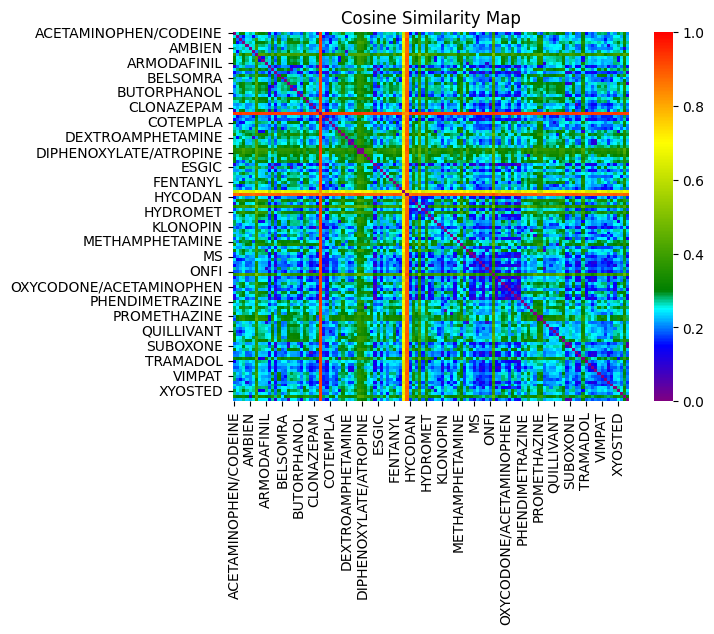

<Figure size 640x480 with 0 Axes>

In [51]:
correlation_df = 1 - grouped_table
correlation_df = correlation_df.astype(float)
# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_df, cmap=cmap, vmin = 0, vmax = 1, annot=False)
plt.title('Cosine Similarity Map')
plt.show()
plt.savefig('correlation_map.jpeg')

In [52]:
filtered_columns = grouped_table.columns[~grouped_table.columns.str.contains('/')]
filtered_df = grouped_table[filtered_columns]

# Filter out rows containing "/"
filtered_rows = grouped_table.index[~grouped_table.index.str.contains('/')]
filtered_df = filtered_df.loc[filtered_rows]

In [53]:
filtered_df

,ADDERALL,ADHANSIA,ADZENYS,ALPRAZOLAM,AMBIEN,AMPHETAMINE,ANDRODERM,ANDROGEL,ARMODAFINIL,BAC,...,VIBERZI,VIMPAT,VYVANSE,XANAX,XCOPRI,XTAMPZA,XYOSTED,ZALEPLON,ZOLPIDEM,ZUBSOLV
ADDERALL,1,0.803311,0.844427,0.767018,0.769762,0.855072,0.7476,0.7454,0.759256,0.717847,...,0.762017,0.78423,0.814923,0.802049,0.789897,0.746478,0.75038,0.784763,0.699249,0.774424
ADHANSIA,0.803311,1,0.805752,0.753938,0.765583,0.725652,0.739877,0.746832,0.728735,0.676291,...,0.785859,0.793319,0.847427,0.781105,0.79366,0.736647,0.732729,0.767211,0.683543,0.770295
ADZENYS,0.844427,0.805752,1,0.738284,0.726609,0.755528,0.702771,0.695031,0.709953,0.651545,...,0.730474,0.744048,0.804459,0.753916,0.752454,0.723207,0.70185,0.732704,0.665127,0.72771
ALPRAZOLAM,0.767018,0.753938,0.738284,1,0.762847,0.741874,0.724802,0.721114,0.737663,0.707493,...,0.748547,0.796786,0.768711,0.893674,0.774603,0.758157,0.725317,0.760062,0.701416,0.765776
AMBIEN,0.769762,0.765583,0.726609,0.762847,1,0.738587,0.747498,0.752661,0.758052,0.702818,...,0.789843,0.793438,0.796508,0.8078,0.802858,0.745768,0.740569,0.802739,0.893837,0.77783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XTAMPZA,0.746478,0.736647,0.723207,0.758157,0.745768,0.731931,0.720937,0.725804,0.721577,0.726731,...,0.758257,0.761126,0.76178,0.806975,0.766133,1,0.729825,0.759458,0.675921,0.807081
XYOSTED,0.75038,0.732729,0.70185,0.725317,0.740569,0.727257,0.855456,0.864824,0.725431,0.706756,...,0.743226,0.767977,0.749523,0.780189,0.771379,0.729825,1,0.752483,0.657899,0.747398
ZALEPLON,0.784763,0.767211,0.732704,0.760062,0.802739,0.759507,0.759556,0.750401,0.75766,0.729209,...,0.788305,0.794166,0.788693,0.813964,0.804802,0.759458,0.752483,1,0.709561,0.785216
ZOLPIDEM,0.699249,0.683543,0.665127,0.701416,0.893837,0.680301,0.664315,0.661207,0.686651,0.634833,...,0.69941,0.704526,0.711549,0.720545,0.714609,0.675921,0.657899,0.709561,1,0.694648


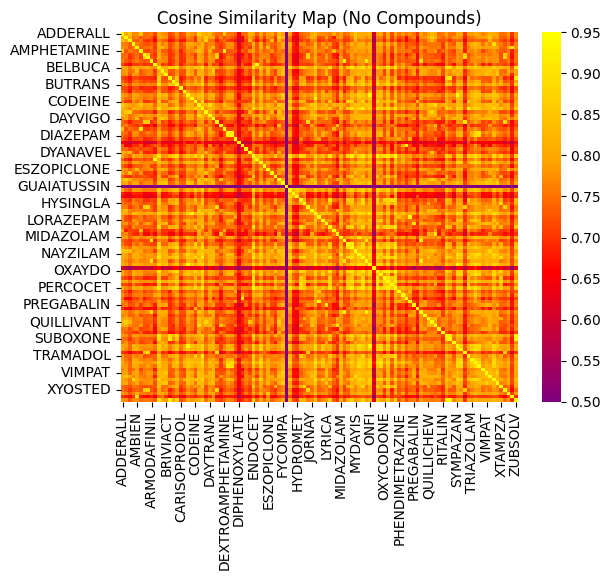

<Figure size 640x480 with 0 Axes>

In [83]:
gradient_ranges = [0, 0.35, 0.65, 1.0]
colors = ['purple', 'red', 'orange', 'yellow']

# Create a custom colormap using the defined ranges and colors
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(gradient_ranges, colors)))

correlation_df = filtered_df.astype(float)
# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_df, cmap=cmap, vmin = 0.5, vmax = 0.95, annot=False)
plt.title('Cosine Similarity Map (No Compounds)')
plt.show()
plt.savefig('correlation_map.jpeg')

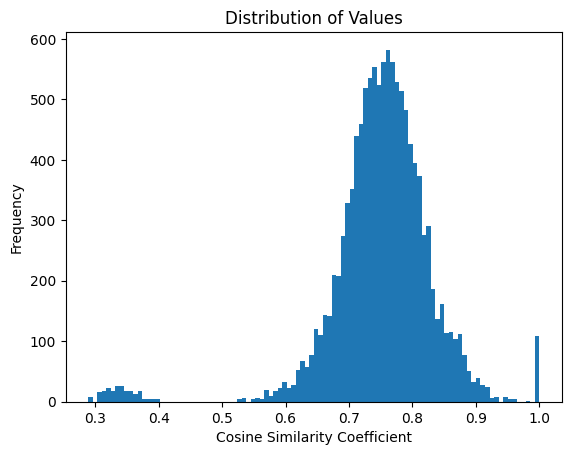

In [68]:
values = filtered_df.values.flatten()

# Create a histogram
plt.hist(values, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Cosine Similarity Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.show()

In [31]:
def drug_similarity_table_v3(ref_table, drug_dict):

    start_time = time.time()

    avg_similarity_table = pd.DataFrame(columns=list(ref_table['NDC_PROD_NAME']), index=list(ref_table['NDC_PROD_NAME']))

    for i in range(len(ref_table)):

            i_drug_name = ref_table.iloc[i][0]
            i_sanitized_drug_name = re.sub(r'[\/:*?"<>| ]+', '_', i_drug_name) + "_p"

            for g in range(len(ref_table)):

                g_drug_name = ref_table.iloc[g][0]
                g_sanitized_drug_name = re.sub(r'[\/:*?"<>| ]+', '_', g_drug_name) + "_p"

                if i == g:
                    avg_similarity_table.loc[i_drug_name, g_drug_name] = 1

                else:
                    if i < g:    

                        i_drug_list = []
                        g_drug_list = []

                        for j, j_pkg_path in enumerate(drug_dict):

                            j_pkg_name = os.path.basename(j_pkg_path)

                            if i_sanitized_drug_name in j_pkg_name:
                                i_drug_list.append(drug_dict[j_pkg_path])

                        for k, k_pkg_path in enumerate(drug_dict):
                            k_pkg_name = os.path.basename(k_pkg_path)

                            if g_sanitized_drug_name in k_pkg_name:
                                g_drug_list.append(drug_dict[k_pkg_path])

                        #print(i_drug_name, i_drug_list,"\n")
                        #print(g_drug_name, g_drug_list,"\n\n")
                        
                        vectorizer = TfidfVectorizer()
                        tfidf_matrix = vectorizer.fit_transform(i_drug_list + g_drug_list)
                        df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
                        similarity_matrix = cosine_similarity(df_tfidf)
                        df_similarity = pd.DataFrame(similarity_matrix, index=df_tfidf.index, columns=df_tfidf.index)

                        average_similarity = df_similarity.iloc[:len(i_drug_list), -len(g_drug_list):].sum().sum() / df_similarity.iloc[:len(i_drug_list), -len(g_drug_list):].size

                        avg_similarity_table.loc[i_drug_name, g_drug_name] = average_similarity

                        #print(f"The average similarity between {i_drug_name} and {g_drug_name} is {average_similarity} \n\n")

                    else:
                        avg_similarity_table.loc[i_drug_name, g_drug_name] = avg_similarity_table.loc[g_drug_name, i_drug_name]
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print("Similarity Table Constructed!")
    print("Execution Time:", execution_time, "seconds")    
    
    return avg_similarity_table

In [91]:
cosine_sim_table_v3 = drug_similarity_table_v3(grouped_by_prod_name, drug_dict)

Similarity Table Constructed!
Execution Time: 356.6193082332611 seconds


In [32]:
test_table_v3 = drug_similarity_table_v3(grouped_by_prod_name, drug_dict)

Similarity Table Constructed!
Execution Time: 389.82985186576843 seconds


In [34]:
test_table_v3

,ACETAMINOPHEN/CODEINE,ACETAMINOPHEN/CODEINE PHO,ADDERALL,ADDERALL XR,ADHANSIA XR,ADZENYS XR-ODT,ALPRAZOLAM,ALPRAZOLAM ER,ALPRAZOLAM ODT,ALPRAZOLAM XR,...,VIMPAT,VYVANSE,XANAX,XCOPRI,XTAMPZA ER,XYOSTED,ZALEPLON,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZUBSOLV
ACETAMINOPHEN/CODEINE,1,0.957127,0.766578,0.667016,0.6745,0.63664,0.763112,0.687233,0.747685,0.68519,...,0.711701,0.693918,0.794506,0.724984,0.746489,0.675443,0.6897,0.642803,0.611016,0.795209
ACETAMINOPHEN/CODEINE PHO,0.957127,1,0.762299,0.679087,0.674675,0.65152,0.7452,0.692436,0.739281,0.696272,...,0.697502,0.692717,0.788525,0.717615,0.761885,0.677608,0.653389,0.615865,0.590624,0.793329
ADDERALL,0.766578,0.762299,1,0.848218,0.773594,0.813858,0.76837,0.719898,0.804405,0.763471,...,0.798536,0.810129,0.826696,0.802792,0.765335,0.769126,0.766118,0.706083,0.67374,0.795272
ADDERALL XR,0.667016,0.679087,0.848218,1,0.833028,0.874996,0.664707,0.688951,0.732734,0.791531,...,0.769924,0.819718,0.777401,0.777002,0.72762,0.731635,0.674623,0.597714,0.600493,0.753575
ADHANSIA XR,0.6745,0.674675,0.773594,0.833028,1,0.805752,0.697831,0.681504,0.754916,0.786692,...,0.793319,0.847427,0.781105,0.79366,0.736647,0.732729,0.702009,0.636075,0.619093,0.770295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYOSTED,0.675443,0.677608,0.769126,0.731635,0.732729,0.70185,0.673038,0.65374,0.73328,0.719557,...,0.767977,0.749523,0.780189,0.771379,0.729825,1,0.666456,0.594274,0.575804,0.747398
ZALEPLON,0.6897,0.653389,0.766118,0.674623,0.702009,0.630673,0.753158,0.623271,0.745254,0.661086,...,0.741894,0.745124,0.769215,0.755913,0.682869,0.666456,1,0.69037,0.634377,0.707213
ZOLPIDEM TARTRATE,0.642803,0.615865,0.706083,0.597714,0.636075,0.565632,0.690003,0.58493,0.689513,0.594219,...,0.67017,0.695677,0.70647,0.689962,0.591924,0.594274,0.69037,1,0.890769,0.657637
ZOLPIDEM TARTRATE ER,0.611016,0.590624,0.67374,0.600493,0.619093,0.569695,0.646065,0.684943,0.666322,0.579022,...,0.652148,0.672146,0.674013,0.666694,0.580841,0.575804,0.634377,0.890769,1,0.62155


In [103]:
cosine_sim_table_v3.iloc[:10,:10].to_csv('10by10cosine_sim.csv', index=True)

In [97]:
grouped_table_v3 = grouped_matrix(cosine_sim_table_v3)

In [98]:
filtered_columns = grouped_table_v3.columns[~grouped_table_v3.columns.str.contains('/')]
filtered_df = grouped_table_v3[filtered_columns]

# Filter out rows containing "/"
filtered_rows = grouped_table_v3.index[~grouped_table_v3.index.str.contains('/')]
filtered_df = filtered_df.loc[filtered_rows]

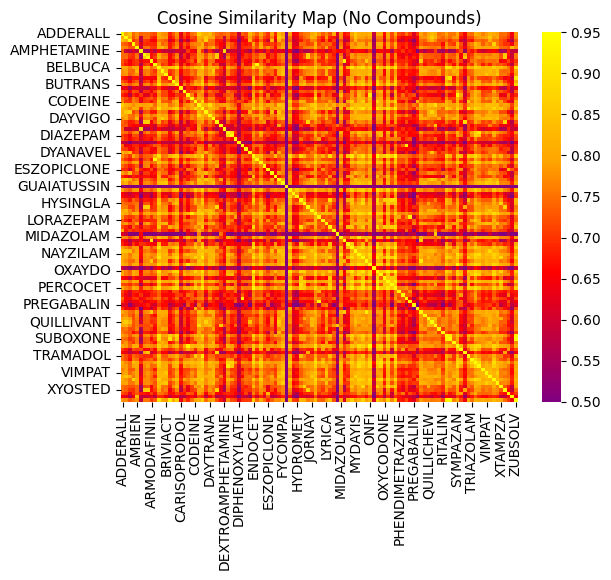

In [101]:
gradient_ranges = [0, 0.35, 0.65, 1.0]
colors = ['purple', 'red', 'orange', 'yellow']

# Create a custom colormap using the defined ranges and colors
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(gradient_ranges, colors)))

correlation_df = filtered_df.astype(float)
# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_df, cmap=cmap, vmin = 0.5, vmax = 0.95, annot=False)
plt.title('Cosine Similarity Map (No Compounds)')
plt.show()